# The Display Module

The :mod:`diogenes.display` module provides tools for summarizing/exploring data and the performance of trained classifiers.

## Exploring data

Display provides a number of tools for examining data before they have been fit to classifiers.

We'll start by pulling and organizing the wine dataset. We read a CSV from The Internet using :func:`diogenes.read.read.open_csv_url`.

In [1]:
%matplotlib inline
import diogenes
import numpy as np

wine_data = diogenes.read.open_csv_url('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
    delimiter=';')

We will then separate labels from features using :func:`diogenes.modify.modify.remove_cols`.

In [2]:
labels = wine_data['quality']
M = diogenes.modify.remove_cols(wine_data, 'quality')

Finally, we alter labels to make this into a binary classification problem. (At this point, all Diogenes features are available for binary classification, but other kinds of ML have more limited support).

In [3]:
labels = labels < np.average(labels)

We can look at our summary statistics with :func:`diogenes.display.display.describe_cols`. Like most functions in Diogenes, `describe_cols` produces a Numpy [structured array](http://docs.scipy.org/doc/numpy/user/basics.rec.html).

In [4]:
summary_stats = diogenes.display.describe_cols(M)
print summary_stats.dtype

[('Column Name', 'S20'), ('Count', '<i8'), ('Mean', '<f8'), ('Standard Dev', '<f8'), ('Minimum', '<f8'), ('Maximum', '<f8')]


In [5]:
print summary_stats

[('fixed acidity', 4898, 6.854787668436097, 0.8437820791264506, 3.8, 14.2)
 ('volatile acidity', 4898, 0.27824111882400976, 0.10078425854188974, 0.08, 1.1)
 ('citric acid', 4898, 0.33419150673744386, 0.12100744957029214, 0.0, 1.66)
 ('residual sugar', 4898, 6.391414863209474, 5.071539989333933, 0.6, 65.8)
 ('chlorides', 4898, 0.04577235606369947, 0.02184573768505638, 0.009000000000000001, 0.34600000000000003)
 ('free sulfur dioxide', 4898, 35.30808493262556, 17.005401105808414, 2.0, 289.0)
 ('total sulfur dioxide', 4898, 138.36065741118824, 42.49372602475034, 9.0, 440.0)
 ('density', 4898, 0.9940273764801959, 0.0029906015821480306, 0.98711, 1.03898)
 ('pH', 4898, 3.1882666394446715, 0.15098518431212068, 2.72, 3.82)
 ('sulphates', 4898, 0.48984687627603113, 0.1141141831056649, 0.22, 1.08)
 ('alcohol', 4898, 10.514267047774602, 1.2304949365418656, 8.0, 14.2)]


It's a bit confusing to figure out which numbers go to which statistics using default structured array printing, so we provide :func:`diogenes.display.display.pprint_sa` to make it more readable when we print small structured arrays.

In [6]:
diogenes.display.pprint_sa(summary_stats)

            Column Name Count            Mean     Standard Dev Minimum Maximum
 0        fixed acidity  4898   6.85478766844   0.843782079126     3.8    14.2
 1     volatile acidity  4898  0.278241118824   0.100784258542    0.08     1.1
 2          citric acid  4898  0.334191506737    0.12100744957     0.0    1.66
 3       residual sugar  4898   6.39141486321    5.07153998933     0.6    65.8
 4            chlorides  4898 0.0457723560637  0.0218457376851   0.009   0.346
 5  free sulfur dioxide  4898   35.3080849326    17.0054011058     2.0   289.0
 6 total sulfur dioxide  4898   138.360657411    42.4937260248     9.0   440.0
 7              density  4898   0.99402737648 0.00299060158215 0.98711 1.03898
 8                   pH  4898   3.18826663944   0.150985184312    2.72    3.82
 9            sulphates  4898  0.489846876276   0.114114183106    0.22    1.08
10              alcohol  4898   10.5142670478    1.23049493654     8.0    14.2


Similarly, we have a number of tools that visualize data. They all return figures, in case the user wants to save them or plot them later.

/Users/zar1/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


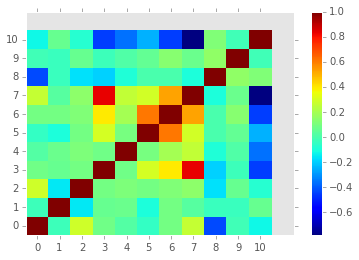

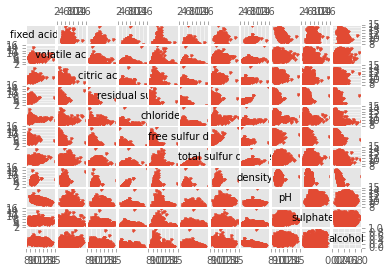

In [7]:
figure = diogenes.display.plot_correlation_matrix(M)
figure = diogenes.display.plot_correlation_scatter_plot(M)

There are also a number of tools for exploring the distribution of data in a single column (ie a 1-dimensional Numpy array)

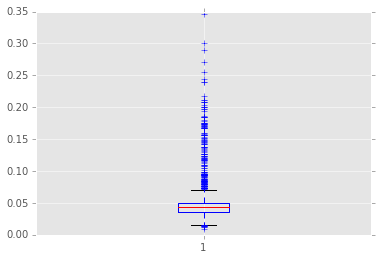

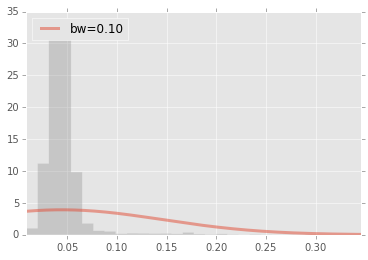

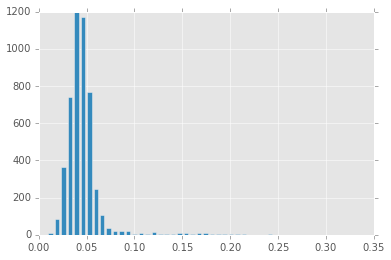

In [9]:
chlorides = M['chlorides']

figure = diogenes.display.plot_box_plot(chlorides)
figure = diogenes.display.plot_kernel_density(chlorides)
figure = diogenes.display.plot_simple_histogram(chlorides)

In [ ]:
diogenes.display.pprint_sa(diogenes.display.crosstab(np.round(chlorides, 1), labels))

## Examining classifier performance.

First, we will arrange and execute a quick grid_search experiment with :class:`diogenes.grid_search.experiment.Experiment`. This will run Random Forest on our data with a number of different hyper-parameters and a number of different train/test splits. See documentation for grid_search for more detail.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfs = [{'clf': RandomForestClassifier, 'n_estimators': [10,50],
         'max_features': ['sqrt','log2'], 'random_state': [0]}]
exp = diogenes.grid_search.experiment.Experiment(M, labels, clfs=clfs)
_ = exp.run()

Now, we will extract a single run, which gives us a single fitted classifier and a single set of test data.

In [ ]:
run = exp.trials[0].runs[0][0]
fitted_classifier = run.clf
# Sadly, SKLearn doesn't like structured arrays, so we have to convert to the other kind of array
M_test = diogenes.utils.cast_np_sa_to_nd(M[run.test_indices])
labels_test = labels[run.test_indices]
scores = fitted_classifier.predict_proba(M_test)[:,1]

We can use our fitted classifier and test data to make an ROC curve or a precision-recall curve showing us how well the classifier performs.

In [ ]:
roc_fig = diogenes.display.plot_roc(labels_test, scores)
prec_recall_fig = diogenes.display.plot_prec_recall(labels_test, scores)

For classifiers that offer feature importances, we provide a convenience method to get the top `n` features.

In [ ]:
top_features = diogenes.display.get_top_features(fitted_classifier, M=M)

For random forest classifiers, we also provide a function to examine consecutive occurence of features in decision trees. see :func:`diogenes.display.display.feature_pairs_in_rf` for more detail.

In [ ]:
results = diogenes.display.feature_pairs_in_rf(fitted_classifier, n=3)

## Making PDF Reports

Finally, diogenes.display provides a simple way to make PDF reports using :class:`diogenes.display.display.Report`.

* Add headings with :meth:`diogenes.display.display.Report.add_heading`
* Add text blocks with :meth:`diogenes.display.display.Report.add_text`
* Add tables with :meth:`diogenes.display.display.Report.add_table`
* Add figures with :meth:`diogenes.display.display.Report.add_fig`
* Build the report with :meth:`diogenes.display.display.Report.to_pdf`

In [ ]:
report = diogenes.display.Report(report_path='display_sample_report.pdf')
report.add_heading('My Great Report About RF', level=1)
report.add_text('I did an experiment with the wine data set '
                '(http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv)')
report.add_heading('Top Features', level=2)
report.add_table(top_features)
report.add_heading('ROC Plot', level=2)
report.add_fig(roc_fig)
full_report_path = report.to_pdf(verbose=False)

Here's the result:

In [ ]:
from IPython.display import HTML
HTML('<iframe src=display_sample_report.pdf width=700 height=350></iframe>')